
Load datasets stored in .tfrecord file format
=======================================

This example demonstrates how to load the data from a stored .tfrecord file and to build a 
data generator.

At first, a small temporary dataset compounding 5 source cases is created by utilizing Dataset1. The conventional beamforming map is included by specifying `sourcemap` as the desired feature.    

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from acoupipe import Dataset1
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # change tensorflow log level for doc purposes


# training dataset
d1 = Dataset1(
        split="training",
        size=5,
        f=1000,
        features=["sourcemap"])

# save to .h5 file
d1.save_tfrecord(name="/tmp/dataset.tfrecord")

100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


To parse the data from TFRecord files it is necessary to write a custom function that parses the file sequentially
(see: TFRecord_ documentation for details).

A potential parser function for the :code:`'sourcemap'` feature can be similar to:


In [3]:

def tfrecord_parser(record):
    """ parser for tfrecord datasets with 'csmtriu' feature """
    parsed = tf.io.parse_single_example(
        record, 
        {
        'sourcemap': tf.io.VarLenFeature(tf.float32),
        'p2': tf.io.VarLenFeature(tf.float32),
        'loc' : tf.io.VarLenFeature(tf.float32),
        }
    )
    sourcemap = tf.reshape(tf.sparse.to_dense(parsed['sourcemap']),shape=(64,64))
    p2 = tf.sparse.to_dense(parsed['p2'])
    loc = tf.reshape(tf.sparse.to_dense(parsed['loc']),[3,-1])  
    return (sourcemap, p2, loc)

Now one can load the Dataset with the TensorFlow Dataset API

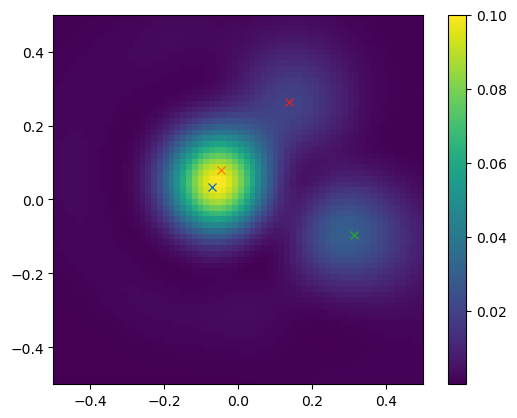

In [6]:

dataset = tf.data.TFRecordDataset(
    filenames=["/tmp/dataset.tfrecord"],
).map(tfrecord_parser)

dataset_iter = iter(dataset)
sourcemap, p2, loc = next(dataset_iter)

plt.figure()
plt.imshow(sourcemap.numpy().T,extent=(-.5,.5,-.5,.5),origin='lower')
for l in loc[:2].numpy().T:
    plt.plot(l[0],l[1],'x')
plt.colorbar()
plt.show()